In [2]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
pip install tensorflow==1.14

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


# Functions needed

In [4]:
# function for face detection with mtcnn
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN

ModuleNotFoundError: No module named 'mtcnn'

In [5]:
# demonstrate face detection on 5 Celebrity Faces Dataset
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed

# Extract and load faces

In [6]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face) #Creates an image memory from an object exporting the array interface 
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

# load images and extract faces for all images in a directory
def load_faces(directory):
    faces = list()
    # enumerate files
    for filename in listdir(directory):
        # path
        path = directory + filename
        # get face
        face = extract_face(path)
        # store
        faces.append(face)
    return faces

# Load all the dataset

In [7]:
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
    X, y = list(), list()
    # enumerate folders, on per class
    for subdir in listdir(directory):
        # path
        path = directory + subdir + '/' 
        # skip any files that might be in the dir
        if not listdir(path):   
            continue    
        # load all faces in the subdirectory
        faces = load_faces(path)
        # create labels
        labels = [subdir for _ in range(len(faces))]
        
        # summarize progress
        print('>loaded %d examples for class: %s' % (len(faces), subdir))
        
        # store 
        X.extend(faces)  #create list with faces iteration 
        y.extend(labels) #create list with labels iteration
    return asarray(X), asarray(y)

In [8]:
import numpy

# load train dataset
trainX, trainy = load_dataset('C:/Users/loren/Desktop/LSBU/Future technologies/CourseWork2/5-celebrity-faces-dataset/train/')
print(trainX.shape, trainy.shape)

# load test dataset
testX, testy = load_dataset('C:/Users/loren/Desktop/LSBU/Future technologies/CourseWork2/5-celebrity-faces-dataset/val/')
print(testX.shape, testy.shape)

# save arrays to one file in compressed format
numpy.savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy) 

NameError: name 'MTCNN' is not defined

# Embedding

In [27]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model


# get the face embedding=incorporamento for one face
def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32') 
    
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std   
    
    # transform face into one sample=campione
    samples = expand_dims(face_pixels, axis=0) #This function expands the array by inserting a new axis at the specified position.
    
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]

In [33]:

#embedding# load the face dataset
data = load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

# load the facenet model
model = load_model('facenet_keras.h5') #facenet model embedd data
print('Loaded Model')

# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)

# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)

# save arrays to one file in compressed form
numpy.savez_compressed('5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)



Loaded:  (113, 160, 160, 3) (113,) (34, 160, 160, 3) (34,)


C:\Users\loren\Anaconda3\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Loaded Model
(113, 128)
(34, 128)


In [34]:
#develop a classifier for the 5 Celebrity Faces Dataset
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

# load dataset
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

# normalize input vectors
in_encoder = Normalizer(norm='l2')    
trainX = in_encoder.transform(trainX) #transform labels to normalized encoding
testX = in_encoder.transform(testX)   

# label encode targets
out_encoder = LabelEncoder() 
out_encoder.fit(trainy)                 #transform non-numerical labels to numerical labels normalizzati
trainy = out_encoder.transform(trainy)  #transform labels to normalized encoding
testy = out_encoder.transform(testy)    

# FIT MODEL
model = SVC(kernel='linear', probability=True)  
model.fit(trainX, trainy)

# PREDICT
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)

# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)

# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=113, test=34
Accuracy: train=100.000, test=100.000


Predicted: madonna (66.401)
Expected: madonna


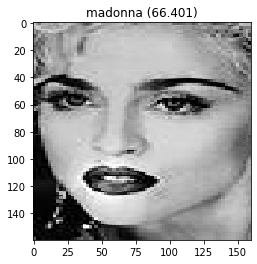

In [35]:
# load faces
data = load('5-celebrity-faces-dataset.npz')
testX_faces = data['arr_2']

from random import choice

# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])  #random cycle where it is choose the position
random_face_pixels = testX_faces[selection] #pick up the images thanks to the position from face_pixels
random_face_emb = testX[selection]  #pick up the images thanks to the position from face_embedding
random_face_class = testy[selection] #pick up the images thanks to the position from face_class
random_face_name = out_encoder.inverse_transform([random_face_class])   #Transform labels back to original encoding

# prediction for the face
samples = expand_dims(random_face_emb, axis=0)  #Expand the shape of an array. Insert a new axis that will appear at the axis position in the expanded array shape.
yhat_class = model.predict(samples) 
yhat_prob = model.predict_proba(samples)

# get name
class_index = yhat_class[0] #give back the picture name
class_probability = yhat_prob[0,class_index] * 100  #percentage
predict_names = out_encoder.inverse_transform(yhat_class) #cancel expand dims

print('Predicted: %s (%.3f)' % (predict_names[0], class_probability)) #name predicted
print('Expected: %s' % random_face_name[0]) #name randam choosen

# plot
pyplot.imshow(random_face_pixels) #Display an image
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()

In [36]:
import PIL

from tkinter import *
from PIL import ImageTk
from PIL import Image

if predict_names[0] == 'totti':
    image=Image.open('C:/Users/loren/Desktop/LSBU/Future technologies/CourseWork2/5-celebrity-faces-dataset/data/val/totti/Roma-Totti.jpg')
    
elif predict_names[0] == 'madonna':
    image=Image.open('C:/Users/loren/Desktop/LSBU/Future technologies/CourseWork2/5-celebrity-faces-dataset/data/val/madonna/httpcdncdnjustjaredcomwpcontentuploadsheadlinesmadonnatalksparisattackstearsjpg.jpg')
    
elif predict_names[0] == 'ben_afflek':
    image=Image.open('C:/Users/loren/Desktop/LSBU/Future technologies/CourseWork2/5-celebrity-faces-dataset/data/val/ben_afflek/httpcsvkmeuadecafjpg.jpg')
    
elif predict_names[0] == 'jerry_seinfeld':
    image=Image.open('C:/Users/loren/Desktop/LSBU/Future technologies/CourseWork2/5-celebrity-faces-dataset/data/val/jerry_seinfeld/httpaurorasblogcomwpcontentuploadsjerryseinfeldpublicityshotjpg.jpg')
    
elif predict_names[0] == 'mindy_kaling':
    image=Image.open('C:/Users/loren/Desktop/LSBU/Future technologies/CourseWork2/5-celebrity-faces-dataset/data/val/mindy_kaling/httpafilesbiographycomimageuploadcfillcssrgbdprgfacehqwMTIOTcwODQNTUzNjQMzcjpg.jpg')

    
elif predict_names[0] == 'elton_john':
    image=Image.open('C:/Users/loren/Desktop/LSBU/Future technologies/CourseWork2/5-celebrity-faces-dataset/data/val/elton_john/httpafilesbiographycomimageuploadcfillcssrgbdprgfacehqwMTEODAOTcxNjcMjczMjkzjpg.jpg')
    
elif predict_names[0] == 'di_Caprio':
    image=Image.open('C:/Users/loren/Desktop/LSBU/Future technologies/CourseWork2/5-celebrity-faces-dataset/data/val/di_Caprio/10.jpg')


In [ ]:
root = Tk()
root.title('FACE DETECTION - Course Work 2 - FIT')

image1 = ImageTk.PhotoImage(image)
label = Label(image = image1)
label.pack()
                          
root.mainloop()                     